# Intro Exercise: Managing Taxi Trajectories

In this exercise, we will implement a prototypical information system for managing trajectories.

We assume that we manage sets of trajectories (of taxis).

For testing, we have provided a dataset with trajectory data ($Lat x Long$) of one taxi.

TaxiID| Timestamp            | Latitude    | Longitude
------|----------------------|-------------|-----------
1     | 2008-02-02 15:36:08  |  116.51172  | 39.92123
1     | 2008-02-02 15:46:08  |  116.51135  | 39.93883
1     | 2008-02-02 15:56:08  |  116.51627  | 39.91034

In this exercise we will first understand the provided data, then model a trajectory and perform functions on top of it. Finally, we will integrate a different data source into the existing data. 

Two datasets are provided: **_taxi_log.txt_** and **_taxi_data_routes.csv_**.

In [2]:
# import libraries
import numpy as np
from datetime import datetime
import pandas as pd

# Import taxi data (taxi_log.txt)
FILE = 'taxi_log.txt'
dt = pd.read_csv(FILE, names = ['tid','timestamp','x','y'])
dt

,tid,timestamp,x,y
0,1,2008-02-02 15:36:08,116.51172,39.92123
1,1,2008-02-02 15:46:08,116.51135,39.93883
2,1,2008-02-02 15:46:08,116.51135,39.93883
3,1,2008-02-02 15:56:08,116.51627,39.91034
4,1,2008-02-02 16:06:08,116.47186,39.91248
...,...,...,...,...
583,1,2008-02-08 15:11:31,116.48347,39.91954
584,1,2008-02-08 15:21:31,116.50789,39.93128
585,1,2008-02-08 15:31:31,116.53174,39.91536
586,1,2008-02-08 15:41:31,116.57156,39.90263


### Data exploration

Before starting implementing the modeling of the taxi trajectories, we will take a deeper look into the data by plotting the (lat, long) pairs. 

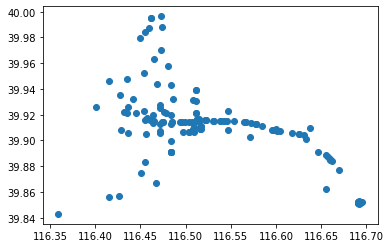

In [3]:
# Visualize data
import matplotlib.pyplot as plt

%matplotlib inline

x_l = list()
y_l = list()

for idx, row in dt.iterrows():
    x_l.append(row['x'])
    y_l.append(row['y'])

x = np.array(x_l)
y = np.array(y_l)

plt.scatter(x, y)
plt.show()

## Question 1: Filter data

Filter specific rows from the trajectory data that have latitude smaller than 116.5.

_HINT: Use pandas Dataframe functions to filter specific rows from the Dataframe._

In [4]:
dt[dt['x'] < 116.5]

,tid,timestamp,x,y
4,1,2008-02-02 16:06:08,116.47186,39.91248
5,1,2008-02-02 16:16:08,116.47217,39.92498
6,1,2008-02-02 16:26:08,116.47179,39.90718
7,1,2008-02-02 16:36:08,116.45617,39.90531
8,1,2008-02-02 17:00:24,116.47191,39.90577
...,...,...,...,...
579,1,2008-02-08 14:31:31,116.48503,39.91422
580,1,2008-02-08 14:41:32,116.44460,39.92156
581,1,2008-02-08 14:51:32,116.40047,39.92594
582,1,2008-02-08 15:01:31,116.44152,39.93236


## Question 2: Create trajectory model

A trajectory $tr$ is modeled as a function from the time domain $T$ to the 2-dimensional coordinate domain $Long\:x\:Lat$. In general, the function can be represented by enumeration or as an algorithm.

Below we define a Trajectory model that contains functions for adding a point, getting the point for a given timestamp, approximating a point, and extracting the sub-trajectories/trips.

Based on the following class:

1. Instantiate a Trajectory object given the input dataset

2. Extract the trips of the created Trajectory object

In [6]:
# the default model
class Trajectory:
    def __init__(self):
        """
        This class represents a trajectory.
        """
        self.path = dict()  # dict[str, tuple], represent the trajectory function as a dictionary (of sample values)
        self.timestamps = list()  # list[datetime.datetime] maintain sorted list of timestamps

    def add_point(self, ts, coord):
        """
        Adds a coordinate point in the Trajectory object.

        :param ts: str, timestamp of the coordinates
        :param coord: np.array, the coordinates
        """
        self.path[ts] = coord
        datetime_obj = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')
        self.timestamps.append(datetime_obj)
        self.timestamps.sort()

    def get_location(self, ts):
        """
        Returns the location for a given timestamp if it exists.

        :param ts: str, the timestamp of the requested location
        :return: np.array, of the coordinates
        """
        return self.path.get(ts, None)

    def get_interpolated_location(self, ts):
        """
        Interpolates the positions, i.e. creating a new function in the model, based on data.

        :param ts: str, the timestamp of the requested location
        :return: np.array, of the coordinates of the interpolated location
        """
        ts = datetime.strptime(ts, '%Y-%m-%d %H:%M:%S')

        if self.timestamps[0] <= ts <= self.timestamps[-1]:
            idx = bisect(self.timestamps, ts)  # get index of the input timestamp in the sorted path

            # get neighbors based on the index
            previous_ts = self.timestamps[idx - 1]
            next_ts = self.timestamps[idx]

            previous_point = self.path[previous_ts.strftime('%Y-%m-%d %H:%M:%S')]
            next_point = self.path[next_ts.strftime('%Y-%m-%d %H:%M:%S')]

            return previous_point + ((previous_point - next_point) / (next_ts - previous_ts).total_seconds()) * (
                (ts - previous_ts).total_seconds())

        return None

    def extract_trips(self):
        """
        Extracting trips, i.e., creating a new representation for trajectories.

        :return: list of lists of np.arrays, with the [start, end] coordinates of the trips 
        """         
        trips = list()
        on_trip = True
        path = list(self.path.values())
        start = path[0]  # get first element
        for i in range(1, len(path)):
            current_point = path[i]
            previous_point = path[i-1]
            
            # compute euclidean distance
            distance = np.sqrt((current_point[0] - previous_point[0]) ** 2 + (current_point[1] - previous_point[1]) ** 2)
            
            if distance < 0.001:
                if on_trip:
                    on_trip = False
                    end = path[i]
                    trips.append((start, end))
            else:
                if not on_trip:
                    start = path[i + 1]
                    on_trip = True

        return trips

In [13]:
# transforming representation as pandas into trajectory object
tr = Trajectory()
for i, position in dt.iterrows():
    tr.add_point(position['timestamp'], position.values[2:])
    
# compute the number of extracted trips
trips = tr.extract_trips()
print(f'Number of extracted trips: {len(trips)}')

Number of extracted trips: 9


## Question 3.1: Implement an alternative trajectory model

In this question you need to implement an alternative representation of the trajectory as a sorted list of pairs for the `add_point()` and `get_location()` methods.

In [53]:
import bisect

class TrajectoryAlt:
    def __init__(self):
        # represent the trajectory function as a dictionary (of sample values)
        self.path = []

    def add_point(self, ts, coord):
        """
        Adds a coordinate point in the Trajectory object.

        :param ts: str, timestamp of the coordinates
        :param coord: np.array, the coordinates
        """
        bisect.insort(self.path, (ts, coord))
        
    def get_location(self, ts):
        """
        Returns the location for a given timestamp if it exists.

        :param ts: str, the timestamp of the requested location
        :return: np.array, of the coordinates
        """
        idx = bisect.bisect_left([x[0] for x in self.path], ts)
        if idx < len(self.path) and self.path[idx][0] == ts:
            return self.path[idx][1]
        else:
            return None

## Question 3.2: Compare models

Compare the two implemented trajectory models in terms of performance. Try to interpret these performance differences.

_HINT: Use the time python library to compute the elapsed time:_

```
start = time.time()
<YOUR CODE>
end = time.time()
print(end - start)
```

In [55]:
import time

tr = Trajectory()
tr_a = TrajectoryAlt()

# TODO: Compare the performance of the models when adding points.
times = []
for m in [tr, tr_a]:
    start = time.time()
    for i, position in dt.drop_duplicates(keep=False).iterrows():
        m.add_point(position['timestamp'], position.values[2:])
    elapsed = time.time() - start
    times.append(elapsed)  
print(f'Adding time TR: {times[0]}, Adding time TR_A: {times[1]}')
    
# TODO: Compare the performance of the models when requesting a point.
for m in [tr, tr_a]:
    start = time.time()
    for i, position in dt.drop_duplicates(keep=False).iterrows():
        m.get_location(position['timestamp'])
    elapsed = time.time() - start
    times.append(elapsed)  
print(f'Requesting time TR: {times[2]}, Requesting time TR_A: {times[3]}')

Adding time TR: 0.038527488708496094, Adding time TR_A: 0.025098562240600586
Requesting time TR: 0.024199247360229492, Requesting time TR_A: 0.03514289855957031


## Question 4: Integrating data from a new source

In this question, we will use another dataset that consists of taxi routes too. 
The goal is to integrate the new data source with the initial dataset into one consolidated dataset.

The provided dataset consist of the routes/trips of one taxi (the one used in previous questions).

route_id | taxi_id | passanger_count | start_point | end_point | route
----------| ----------| ----------| ----------| ---------- | ------
1 | 1 | 3 | (116.511, 39.921) | (116.691, 39.851) | [(116.511, 39.921), ... , (116.691, 39.851)]
2 | 1 | 1 | (116.659, 39.885) | (116.691, 39.851) | [(116.659, 39.885), ... , (116.691, 39.851)]
3 | 1 | 1 | (116.630, 39.904) | (116.691, 39.852) | [(116.630, 39.904), ... , (116.691, 39.852)]

The goal is to create a consilidated dataset with the following columns:
- **taxiID**: the taxi identificator
- **timestamp**: the timestamp of a specific point
- **latitude**: the latitude of the point
- **longitude**: the longitude of the point
- **routeID**: the route that the taxi was doing at that time
- **passangers**: the number of passanger the route had

_HINT: Since this data is in a different format, it needs to be mapped to the representation we have been using for the initial dataset._

In [56]:
# Import additional taxi data (taxi_data_routes.csv)
import ast

FILE = 'taxi_data_routes.csv'
dt_new = pd.read_csv(FILE, names = ['route_id','taxi_id','passanger_count',
                                    'start_point','end_point','route'], sep='|')
dt_new['route'] = dt_new['route'].apply(lambda s: list(ast.literal_eval(s)))
dt_new

,route_id,taxi_id,passanger_count,start_point,end_point,route
0,1,1,3,"[116.51172,39.92123]","[116.69167,39.85166]","[[116.51172, 39.92123], [116.51135, 39.93883],..."
1,2,1,1,"[116.65945,39.88563]","[116.6915,39.85161]","[[116.65945, 39.88563], [116.6174, 39.9057], [..."
2,3,1,1,"[116.63086,39.9044]","[116.69159,39.85204]","[[116.63086, 39.9044], [116.57792, 39.9129], [..."
3,4,1,2,"[116.64668,39.89091]","[116.69155,39.8518]","[[116.64668, 39.89091], [116.59985, 39.90881],..."
4,5,1,1,"[116.5727,39.91361]","[116.48332,39.89113]","[[116.5727, 39.91361], [116.51523, 39.91522], ..."
5,6,1,1,"[116.51238,39.91654]","[116.69158,39.85188]","[[116.51238, 39.91654], [116.51167, 39.92152],..."
6,7,1,2,"[116.59778,39.90824]","[116.69156,39.85179]","[[116.59778, 39.90824], [116.57738, 39.91294],..."
7,8,1,2,"[116.60394,39.90741]","[116.54723,39.90841]","[[116.60394, 39.90741], [116.54559, 39.91474],..."


In [58]:
dt_new['route'][0]

[[116.51172, 39.92123],
 [116.51135, 39.93883],
 [116.51627, 39.91034],
 [116.47186, 39.91248],
 [116.47217, 39.92498],
 [116.47179, 39.90718],
 [116.45617, 39.90531],
 [116.47191, 39.90577],
 [116.50661, 39.9145],
 [116.49625, 39.9146],
 [116.50962, 39.91071],
 [116.52231, 39.91588],
 [116.56444, 39.91445],
 [116.59512, 39.90798],
 [116.65522, 39.8622],
 [116.69164, 39.85165],
 [116.69167, 39.85166]]

In [ ]:
# TODO: Integrate the two data sources into one dataframe
# HINT: 
# - first, expand the points of each route with the .explode pandas function
# - second, merge the two dataframes
# --------- ADD YOUR CODE HERE -----------



# ----------------------------------------

---

## Additional material from the lecture

In this section, we review some key points mentioned in the lecture regarding abstract models and homomorphism.

Run the following examples to get a deeper understanding of these concepts.

#### Different datatypes representing the same model

In [ ]:
dict_tr = {}
dict_tr[0] = [0,0]
dict_tr[1] = [1,0]
dict_tr

In [ ]:
list_tr = []
list_tr.append([0,0])
list_tr.append([1,0])
list_tr

In [ ]:
import pandas as pd
d = {0: [0, 0], 1: [1, 0]}
df = pd.DataFrame(data = d)
df

#### Representation and Homomorphisms

A representation is a relationship among mathematical structures. One example of such a relationship is the relationship among a data structure and its encoding, e.g., as a string.

In general a homomorphism is a mapping $H: X -> Y$ that satisfies for functions $f$ the property $H(f(x)) = f(H(x))$

We define the following Python functions for determining the length of a list of records, once directly once in the encoded format.

Verify by an example that the function is preserved under the mapping to a JSON encoding and thus the encoding is a homomorphism.

In [ ]:
import json

result = dt.to_json(orient="records")
parsed = json.loads(result)

In [ ]:
def R(X):
    if type(X) == 'list':
        return json.dumps(X)
    if type(X) == 'int':
        return X

def length(l):
    if isinstance(l,list):
        return len(l)
    if isinstance(l,str):
        return l.count("],")+1

In [ ]:
R(length(result)) == length(R(result))

#### Not every representation is an (exact) homomorphism

In [ ]:
def timesteps(s, u, n):
    print(s)
    if n == 0:
        return s
    else:
        return timesteps(s + u, u, n-1)

In [ ]:
timesteps(0, 0.2, 10)

What is going wrong. If $R: T -> float$ for mapping the time domain were an exact homomorphism, then for the function $timesteps: Start x Unit x NumberOfSteps -> End$ we would have:

> $R(timesteps(s,u,n)) = timesteps(R(s),R(u),R(n))$

If we take $s = 0$, $u = 0.2$ and $n = 10$, then the function $timesteps(0, 0.2, 10)$ evaluates to 2, and R(2) = 2.

On the other hand, if we evaluate the above function implemented using floating point arithmetic, we obtain as result 1.9999999999999998, which is different.